<a href="https://colab.research.google.com/github/Nighty13/SimpleCNN/blob/master/CustomCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json
from pprint import pprint
from google.colab import auth
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload
import pickle

In [0]:
auth.authenticate_user()
drive_service = build('drive', 'v3')

In [0]:
def _create_file_request(file_id):
    return drive_service.files().get_media(fileId=file_id)


def _download_response_bytes(request, print_progress=False):
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    
    for status in _progbar(downloader):
        if print_progress:
            print("Downloaded {}/{} bytes".format(status.resumable_progress, status.total_size))
  
    downloaded.seek(0)
    return downloaded.read()

  
def _progbar(downloader):
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        yield status


def get_file_id(name):
    return get_matching_files(name)[0]['id']


def move_from_drive_to_disk(file_names, file_destinations):
    for file_name, dest in zip(file_names, file_destinations):
        file_id = get_file_id(file_name)
        print('Downloading file: "{}"'.format(file_name))
        file_bytes = _download_response_bytes(_create_file_request(file_id), print_progress=True)
        with open(dest, "wb") as f:
            f.write(file_bytes)


def load_pickled_files(file_names):
    for name in file_names:
        yield pickle.load(open(name, "rb"))
        

def get_matching_files(name):
    drive_files_response = _download_response_bytes(drive_service.files().list())
    drive_files_response_dict = json.loads(
        drive_files_response.decode('utf-8')
    )
    drive_files_dict = drive_files_response_dict['files']
  
    matching_records = [
        record
        for record in drive_files_dict
        if record['name'] == name
    ]

    no_records = len(matching_records)
    if no_records == 0:
        raise ValueError('no such file: "{}" on your Google Drive'.format(name))
    elif no_records > 1:
        print('warning: multiple matches for file "{}"'.format(name))
    return matching_records

In [84]:
example_file_name = 'CATS_DOGS.zip'
example_file_id = get_file_id(example_file_name)
move_from_drive_to_disk([example_file_name], ['CATS_DOGS.zip'])

Downloaded 104857601/811517079 bytes
Downloaded 209715202/811517079 bytes


KeyboardInterrupt: ignored

In [0]:
!unzip CATS_DOGS.zip

In [0]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [0]:
cat4 = cv2.imread('CATS_DOGS/train/CAT/4.jpg')
cat4 = cv2.cvtColor(cat4,cv2.COLOR_BGR2RGB)
dog=cv2.imread('CATS_DOGS/train/DOG/2.jpg')
dog = cv2.cvtColor(dog,cv2.COLOR_BGR2RGB)

In [0]:
plt.imshow(cat4)

In [0]:
cat4.shape

In [0]:
plt.imshow(dog)
dog.shape

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
image_gen=ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             rescale=1/255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest'
                             )

In [0]:
plt.imshow(image_gen.random_transform(dog))

In [0]:
image_gen.flow_from_directory('CATS_DOGS/train')

In [0]:
input_shape = (150,150,3)

In [0]:
from keras.models import Sequential
from keras.layers import Activation,Dropout,Flatten,Conv2D,MaxPooling2D,Dense

In [0]:
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(150,150,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=(150,150,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=(150,150,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(rate=0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [0]:
model.summary()

In [0]:
batch_size=16
train_image_gen=image_gen.flow_from_directory('CATS_DOGS/train',
                                             target_size=input_shape[:2],
                                             batch_size=batch_size,
                                             class_mode='binary')

In [0]:
test_image_gen=image_gen.flow_from_directory('CATS_DOGS/test',
                                             target_size=input_shape[:2],
                                             batch_size=batch_size,
                                             class_mode='binary')

In [0]:
train_image_gen.class_indices

In [0]:
results=model.fit_generator(train_image_gen,epochs=100,steps_per_epoch=150,
                           validation_data=test_image_gen,validation_steps=12)

In [86]:
results.history['acc']

[0.5216666666666666,
 0.56125,
 0.5841666666666666,
 0.56625,
 0.5766666666666667,
 0.5879166666666666,
 0.6104166666666667,
 0.626097867076041,
 0.6425,
 0.6341666666666667,
 0.67375,
 0.6558333333333334,
 0.68,
 0.6825,
 0.6833333333333333,
 0.7022166458047717,
 0.7120833333333333,
 0.7054166666666667,
 0.7116666666666667,
 0.7,
 0.7325,
 0.7183333333333334,
 0.71875,
 0.7394395651103363,
 0.7354166666666667,
 0.7229166666666667,
 0.7445833333333334,
 0.7325,
 0.7395833333333334,
 0.7516666666666667,
 0.7325,
 0.750313676360859,
 0.755,
 0.7570833333333333,
 0.7545833333333334,
 0.75625,
 0.7804166666666666,
 0.7625,
 0.7566666666666667,
 0.767879548306148,
 0.7654166666666666,
 0.7658333333333334,
 0.7708333333333334,
 0.755,
 0.7875,
 0.7766666666666666,
 0.7779171894854056,
 0.77125,
 0.7925,
 0.7870833333333334,
 0.7716666666666666,
 0.7858333333333334,
 0.7995833333333333,
 0.7870833333333334,
 0.7942283563611897,
 0.79625,
 0.78875,
 0.805,
 0.78,
 0.7875,
 0.7904166666666667,


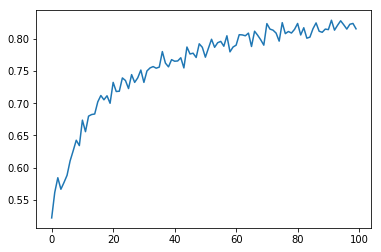

In [87]:
plt.plot(results.history['acc'])

In [105]:
from tensorflow import keras
from tensorflow.keras import layers
model.save("model.h5")
print("Saved model to disk")
# Recreate the exact same model purely from the file
new_model = keras.models.load_model('model.h5')
print("Loaded new model")

Saved model to disk
Loaded new model


In [0]:
from keras.models import load_model

In [93]:
dog_file='CATS_DOGS/test/CAT/10005.jpg'
from keras.preprocessing import image
dog_img=image.load_img(dog_file,target_size=(150,150))
dog_img=image.img_to_array(dog_img)
dog_img.shape

(150, 150, 3)

In [0]:
import numpy as np
dog_img=np.expand_dims(dog_img,axis=0)
dog_img=dog_img/255

In [95]:
dog_img.shape

(1, 150, 150, 3)

In [106]:
model.predict_classes(dog_img)

array([[0]], dtype=int32)